In [20]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

In [21]:
save = False

In [22]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.score"

In [23]:
categories = ['original',
            'scrambled1',
            'scrambled3',
            'scrambled5',
            'scrambled7',
            'backward',
            'lowpmi',
            'lowpmi-random',
            'random-wl',
            'nouns',
            'nounsverbs',
            'nounsverbsadj',
            'contentwords',
            'random-nouns',
            'functionwords',
            'sentenceshuffle_passage',
            'sentenceshuffle_topic',
            'sentenceshuffle_random']

In [24]:
def get_max_score(matrix):
    """
    input: result = out['data'].values matrix (e.g. for distilgpt2 a matrix of dimensions 7x2)
    output: maximum score and associated error for this matrix.
    """
    max_score, error = 0,0
    for i in range(len(matrix)):
        if matrix[i][0] > max_score:
            max_score = matrix[i][0]
            error = matrix[i][1]
    return max_score, error

In [25]:
from brainio_base.assemblies import DataAssembly, merge_data_arrays
from brainscore.metrics import Score

from scipy.stats import median_abs_deviation

def aggregate_neuroid_scores(neuroid_scores, subject_column):
    subject_scores = neuroid_scores.groupby(subject_column).median()
    center = subject_scores.median(subject_column)
    subject_values = np.nan_to_num(subject_scores.values, nan=0)  # mad cannot deal with all-nan in one axis, treat as 0
    subject_axis = subject_scores.dims.index(subject_scores[subject_column].dims[0])
    error = median_absolute_deviation(subject_values, axis=subject_axis)
    score = Score([center, error], coords={'aggregation': ['center', 'error']}, dims=['aggregation'])
    score.attrs['raw'] = neuroid_scores
    score.attrs['description'] = "score aggregated by taking median of neuroids per subject, " \
                                 "then median of subject scores"
    return score

In [26]:
#aggregation from pipeline
from brainscore.metrics.transformations import  apply_aggregate

def get_md_score(content_of_picklefile):
    md_score_matrix = []
    all_raw_scores = content_of_picklefile["data"].raw.raw.raw
    
    # same as https://github.com/carina-kauf/perturbed-neural-nlp/blob/master/neural_nlp/benchmarks/neural.py#L173
    raw_neuroids = apply_aggregate(lambda values: values.mean('split').mean('experiment'), all_raw_scores)
    md_neuroids = raw_neuroids.sel(atlas='visual', _apply_raw=False)
    layers = list(md_neuroids.layer.data)
    
    for layer in layers:
        md_neuroids.sel(layer=layer)
        score = aggregate_neuroid_scores(md_neuroids.sel(layer=layer), "subject")
#         print(f"{layer} | Score: {score.data}")
        md_score_matrix.append(score.data)
    return md_score_matrix

In [27]:
def get_best_scores_df(model_identifier, categories,
                       emb_context="Sentence", split_coord="Sentence",
                       testonperturbed=False):
    """
    input: model_identifier
    output: dictionary containing the maximum score and associated error per condition.
            structure of dictionary: condition --> {score --> max_score, error --> associated error}
    """
    conditions = []
    max_scores = []
    errors = []
    
    for filename in os.listdir(working_dir):
        if os.path.isdir(os.path.join(working_dir,filename)):
            continue
            
        if not testonperturbed:
            if "teston:" in filename:
                continue
        else:
            if not "teston:" in filename:
                continue
                
        if not f"emb_context={emb_context}" in filename:
            continue
                
        if not f"split_coord={split_coord}" in filename:
            continue            
                
        include_condition = False
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
            
            if any(x in filename for x in ["encoding-scrambled", "encoding-perturb"]):

                condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
                
                condition = re.sub("perturb-","",condition)
                condition = re.sub("scrambled-","",condition)

                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    out = pickle.load(f)
                result = out['data'].values
                md_score_matrix = get_md_score(out)
#                 print(md_score_matrix, '\n\n')
                max_score, error = get_max_score(md_score_matrix)
                
                conditions.append(condition)
                max_scores.append(max_score)
                errors.append(error)
                
    import pandas as pd
    index = conditions
    df = pd.DataFrame({'score': max_scores,
    'error': errors, 'condition': conditions})
    df['condition'] = pd.Categorical(df['condition'], categories=categories)
    scores_df = df.sort_values(by='condition')
    return scores_df

In [28]:
#function check
scores_df = get_best_scores_df(model_identifier="distilgpt2",categories=categories)
scores_df

/om2/user/ckauf/anaconda39/envs/perturbed3.8/lib/python3.8/site-packages/xarray/core/nanops.py:159: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_38728/3851150132.py:11: DeprecationWarning:

`median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.


/om2/user/ckauf/anaconda39/envs/perturbed3.8/lib/python3.8/site-packages/xarray/core/dataarray.py:219: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



,score,error,condition
11,0.112532,0.018799,original
13,0.110247,0.018740,scrambled1
14,0.117115,0.031771,scrambled3
15,0.123429,0.027556,scrambled5
16,0.118899,0.020579,scrambled7
8,0.105445,0.010419,backward
9,0.104310,0.026001,lowpmi
10,0.100955,0.019010,lowpmi-random
12,0.011444,0.013291,random-wl
2,0.095635,0.021567,nouns


In [29]:
brainscores = list(scores_df["score"])
delta_brainscores = [brainscores[i] - brainscores[0] for i in range(len(brainscores))]
scores_df["delta_brainscore"] = delta_brainscores
scores_df.head()

,score,error,condition,delta_brainscore
11,0.112532,0.018799,original,0.000000
13,0.110247,0.018740,scrambled1,-0.002284
14,0.117115,0.031771,scrambled3,0.004583
15,0.123429,0.027556,scrambled5,0.010897
16,0.118899,0.020579,scrambled7,0.006367


In [30]:
surprisal_path = os.path.abspath("../gpt2_surprisals/files")

#distilgpt2.perturbed+contentwords.sentence_surp.average.txt
#Index	Sentence	Surprisal	PPL

In [31]:
COND2SET = {
'Original' : 'original',
    #
'Scr1' : 'scrambled',
'Scr3' : 'scrambled',
'Scr5' : 'scrambled',
'Scr7' : 'scrambled',
'backward' : 'scrambled',
'lowPMI' : 'scrambled',
'random' : 'scrambled',
'nouns' : 'perturbed',
'randomnouns' : 'perturbed',
'nounsverbs' : 'perturbed',
'nounsverbsadj' : 'perturbed',
'contentwords' : 'perturbed',
'functionwords' : 'perturbed',
    #
'sentenceshuffle-random' : 'perturbed',
'sentenceshuffle-withinpassage' : 'perturbed',
'sentenceshuffle-withintopic' : 'perturbed'
}

In [32]:
CONDMAP = [ #same name between brainscores and surprisals
('Original', 'original'),
    #
('Scr1', 'scrambled1'),
('Scr3', 'scrambled3'),
('Scr5', 'scrambled5'),
('Scr7', 'scrambled7'),
('backward', 'backward'),
('lowPMI', 'lowpmi'),
('random', 'random-wl'),
('nouns', 'nouns'),
('randomnouns', 'random-nouns'),
('nounsverbs', 'nounsverbs'),
('nounsverbsadj', 'nounsverbsadj'),
('contentwords', 'contentwords'),
('functionwords', 'functionwords')
]

In [33]:
model_identifier = "distilgpt2"

In [34]:
conditions, categories, avg_surprisal = [], [], []
for (cond, category) in CONDMAP:
    print(cond)
    scr_perturb = COND2SET[cond]
    computed = True
    filename = f"{model_identifier}.{scr_perturb}+{cond}.sentence_surp.average_sentlength.txt"
    try:
        content = pd.read_csv(os.path.join(surprisal_path, filename), sep="\t")
        avg_surprisal.append(content["Surprisal"].mean())
        conditions.append(category)
        categories.append(scr_perturb)
    except:
        print(f"Ignoring condition {cond}")
surprisal_df = pd.DataFrame({
    "condition" : conditions,
    "category" : categories,
    "distilgpt2_surprisal" : avg_surprisal
})

delta_surprisal = [avg_surprisal[0] - avg_surprisal[i] for i in range(len(conditions))]

surprisal_df["delta_surprisal"] = delta_surprisal
surprisal_df.head()

Original
Scr1
Scr3
Scr5
Scr7
backward
lowPMI
random
nouns
randomnouns
nounsverbs
nounsverbsadj
contentwords
functionwords


,condition,category,distilgpt2_surprisal,delta_surprisal
0,original,original,6.320380,0.000000
1,scrambled1,scrambled,7.356871,-1.036491
2,scrambled3,scrambled,8.034630,-1.714250
3,scrambled5,scrambled,8.447436,-2.127056
4,scrambled7,scrambled,9.452005,-3.131625


In [35]:
plot_df = surprisal_df.merge(scores_df, how='inner', on='condition')
plot_df

,condition,category,distilgpt2_surprisal,delta_surprisal,score,error,delta_brainscore
0,original,original,6.320380,0.000000,0.112532,0.018799,0.000000
1,scrambled1,scrambled,7.356871,-1.036491,0.110247,0.018740,-0.002284
2,scrambled3,scrambled,8.034630,-1.714250,0.117115,0.031771,0.004583
3,scrambled5,scrambled,8.447436,-2.127056,0.123429,0.027556,0.010897
4,scrambled7,scrambled,9.452005,-3.131625,0.118899,0.020579,0.006367
5,backward,scrambled,10.457505,-4.137125,0.105445,0.010419,-0.007086
6,lowpmi,scrambled,10.303523,-3.983143,0.104310,0.026001,-0.008221
7,random-wl,scrambled,11.098599,-4.778219,0.011444,0.013291,-0.101088
8,nouns,perturbed,14.699303,-8.378923,0.095635,0.021567,-0.016897
9,nounsverbs,perturbed,11.983525,-5.663145,0.092689,0.023615,-0.019843


Correlation: 0.41850140730373125


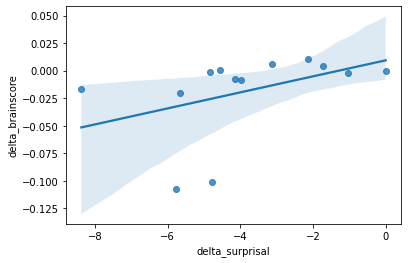

In [36]:
print(f"Correlation: {plot_df['delta_surprisal'].corr(plot_df['delta_brainscore'])}")
sns.regplot(x="delta_surprisal", y="delta_brainscore", data=plot_df)
plt.show()

In [37]:
import plotly.express as px
fig = px.scatter(plot_df, x="delta_surprisal", y="delta_brainscore", color="category", hover_data=["condition"],
                size="error", trendline="ols")
fig.show()

In [38]:
no_outliers = plot_df.loc[~plot_df["condition"].isin(["functionwords","random-wl"])]

fig = px.scatter(no_outliers, x="delta_surprisal", y="delta_brainscore", color="category", hover_data=["condition"],
                size="error", trendline="ols")
fig.show()